In [ ]:
from math import sqrt
import pandas as pd
import numpy as np
import os
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder


path = "/content/drive/MyDrive/dataset/raw data.csv"
data = pd.read_csv(path)

data = pd.get_dummies(data) #convert categorical variable into dummy variable

y = np.array(data['PDOs PY (%)']) #output feature
X = data.drop(['CR (%)', 'ECR PY (%)', 'PDOs PY (%)', 'POHs PY (%)', 'I'], axis=1) #input feature - axis=1 refers to the column


X_list = list(X.columns) # Saving feature names for later use

from sklearn.preprocessing import StandardScaler #standardscaler for normalization (Jinesh et al., 2023)
scaler = StandardScaler()

y = y.reshape(-1, 1) #normalizing y
scaler.fit(y)
y = scaler.transform(y)

scaler.fit(X) #normalizing X
X = scaler.transform(X)

X = np.array(X) # Convert to numpy array

# Using Skicit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size = 0.3, random_state = 42)
print('Training X Shape:', train_X.shape)
print('Training y Shape:', train_y.shape)
print('Testing X Shape:', test_X.shape)
print('Testing y Shape:', test_y.shape)

#imputation for missing value using kNN algo
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=10) #create an instance of KNNImputer class, k is desired number of neighbours

#perform imputation on on X because y no missing values
imp_train_X = imputer.fit_transform(train_X)
imp_test_X = imputer.fit_transform(test_X)

#hyperparamter optimization using gridsearch
random_cv = GridSearchCV(
            estimator=XGBRegressor(),
            param_grid={'learning_rate': [0.05, 0.30, 0.50, 0.70, 1.0], #0.05 - 0.05, 0.10, 0.30, 0.50, 1.0
                        'n_estimators': [100, 500, 1000, 3000, 5000], #3000 -
                        'max_depth': [2, 3, 4, 5, 6], #4 -
                        'min_child_weight': [2, 4, 6, 8, 10], #2 -
                        #'gamma':[0, 0.2, 0.4], #0 - 0, 0.2, 0.4, 0.6, 0.8
                        #'alpha': [0, 0.2, 0.4], #0 - 0, 0.2, 0.4, 0.6, 0.8
                        #'lambda': [0, 0.2, 0.4] #0 - 0, 0.2, 0.4, 0.6, 0.8
                        },
            cv=3, scoring='r2', verbose=0, n_jobs=-1)
#This includes 3-fold validation (cv=3) and uses mean scare error as the metric for evaluation
#if you prefer a quieter training process without any output messages, you can set verbose to 0

random_cv.fit(imp_train_X,train_y)

# use the best parameters
best_params = random_cv.best_params_
best_score = random_cv.best_score_
print('\n Best hyperparameters:', best_params)
print('\n Best score:', best_score)

# # using the best parameters run XGBoost
# model = XGBRegressor(**best_params)
# model.fit(imp_train_X, train_y)

# #check the validation
# score = model.score(imp_train_X,train_y)
# print("Training score: ", score)

# predictions = model.predict(imp_test_X)

# print("Mean Absolute Error: " + str(mean_absolute_error(test_y, predictions)))
# print("MSE: " + str(mean_squared_error(predictions, test_y)))

# RMSE = sqrt(mean_squared_error(predictions, test_y))

# print("RMSE: " + str(RMSE))
# print("R2 score: " + str(r2_score(test_y, predictions)))

Training X Shape: (312, 27)
Training y Shape: (312, 1)
Testing X Shape: (134, 27)
Testing y Shape: (134, 1)


Training X Shape: (312, 30)
Training y Shape: (312,)
Testing X Shape: (134, 30)
Testing y Shape: (134,)
Training score:  0.9999073244519947
Mean Absolute Error: 1.6537416583507698
MSE: 23.915650253728245
RMSE: 4.890362998155479
R2 score: 0.8037922670962948
[ 0.91557657  0.85591168  0.92167506  0.88256662 -1.30053167  0.94653371
  0.70519311  0.09336347  0.50293527  0.93920975]


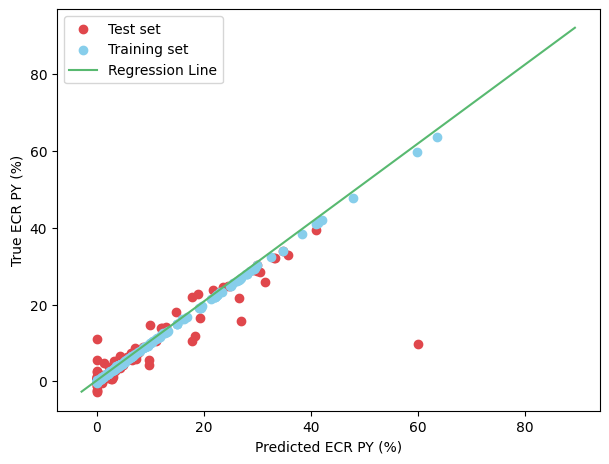

In [2]:
!pip install shap
!pip install joypy
from math import sqrt
import pandas as pd
import numpy as np
import seaborn as sns
import os
import shap
import joypy
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

path = "/content/drive/MyDrive/dataset/raw data.csv"
data = pd.read_csv(path)

data = pd.get_dummies(data) #convert categorical variable into dummy variable

yo = np.array(data['PDOs PY (%)']) #output feature
Xi = data.drop(['CR (%)', 'ECR PY (%)', 'PDOs PY (%)', 'POHs PY (%)', 'V'], axis=1) #input feature - axis=1 refers to the column


Xi_list = list(Xi.columns) # Saving feature names for later use

#from sklearn.preprocessing import StandardScaler #standardscaler for normalization (Jinesh et al., 2023)
#scaler = StandardScaler()

#yo = yo.reshape(-1, 1) #normalizing y
#scaler.fit(yo)
#yo = scaler.transform(yo)

#scaler.fit(Xi) #normalizing X
#Xi = scaler.transform(Xi)

Xi = np.array(Xi) # Convert to numpy array

# Using Skicit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
train_X, test_X, train_y, test_y = train_test_split(Xi, yo, test_size = 0.3, random_state = 42)
print('Training X Shape:', train_X.shape)
print('Training y Shape:', train_y.shape)
print('Testing X Shape:', test_X.shape)
print('Testing y Shape:', test_y.shape)

#imputation for missing value using kNN algo
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=10) #create an instance of KNNImputer class, k is desired number of neighbours

#perform imputation on on X because y no missing values
imp_train_X = imputer.fit_transform(train_X)
imp_test_X = imputer.fit_transform(test_X)

#xgboost regression
model = XGBRegressor(learning_rate=0.1, max_depth=5, min_child_weight=4, n_estimators=3000, reg_alpha=0, gamma=0, reg_lambda=0) #already in default - reg_alpha=0, gamma=0, reg_lambda=0, learning_rate=0.1, max_depth=4, min_child_weight=2, n_estimators=1000
model.fit(imp_train_X, train_y,
          eval_set=[(imp_test_X, test_y)],
          verbose=False)

score = model.score(imp_train_X,train_y)
print("Training score: ", score)

predictions = model.predict(imp_test_X) #predicted, expected = test_y

print("Mean Absolute Error: " + str(mean_absolute_error(test_y, predictions)))
print("MSE: " + str(mean_squared_error(predictions, test_y)))

RMSE = sqrt(mean_squared_error(predictions, test_y))
r2score = r2_score(test_y, predictions)

print("RMSE: " + str(RMSE))
print("R2 score: " + str(r2score))

#draw draw draw!
import matplotlib.pyplot as plt

plt.xlim(-10,80)
plt.ylim(-10,80)

# Plot the predicted values
plt.scatter(test_y, predictions, color='#e0474c', label='Test set') #real values call

train_predictions = model.predict(imp_train_X)
plt.scatter(train_y, train_predictions, color='#87ceeb', label='Training set') #real values call

plt.xlabel("Predicted ECR PY (%)")
plt.ylabel("True ECR PY (%)")
plt.tight_layout()

# Perform K-Fold CV
scores = cross_val_score(model, imp_train_X, train_y, cv=10, scoring='r2')
print(scores)

#regression line
X = predictions
Y = test_y

# Mean X and Y
mean_x = np.mean(X)
mean_y = np.mean(Y)

# Total number of values
n = len(X)

# Using the formula to calculate 'm' and 'c'
numer = 0
denom = 0
for i in range(n):
 numer += (X[i] - mean_x) * (Y[i] - mean_y)
 denom += (X[i] - mean_x) ** 2
 m = numer / denom #least square method
 c = mean_y - (m * mean_x)

# Plotting Values and Regression Line
max_x = np.max(X) + 50 #extrapolating
min_x = np.min(X) - 0

# Calculating line values x and y
x = np.linspace(min_x, max_x, 1000)
y = c + m * x
ax = plt.plot(x, y, color='#58b970', label='Regression Line')

#plt.plot([0, 80], [0, 80], color='black', label='Regression line')
#plt.plot(x_sorted, y_pred_sorted,  color='black', label='Regression line')
plt.axis('tight')
plt.legend()


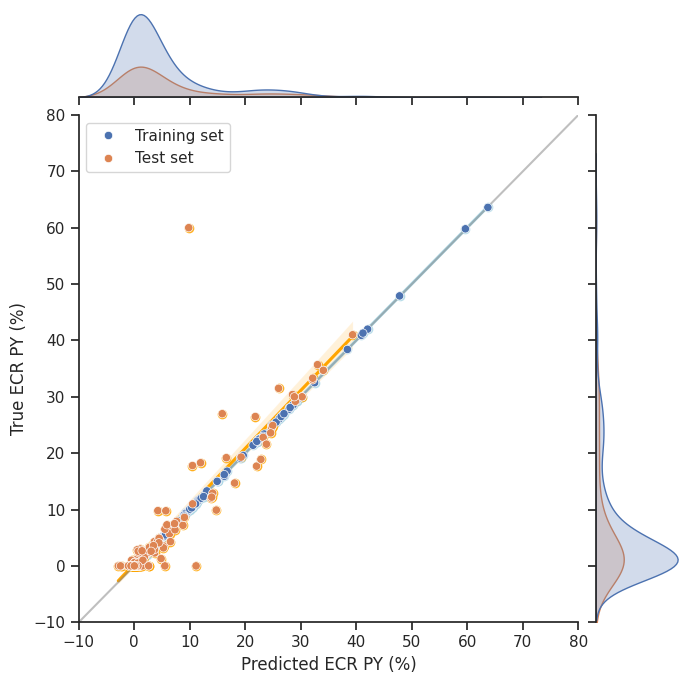

In [3]:
from seaborn._core.properties import FontSize
import seaborn as sns

#draw draw draw!
import matplotlib.pyplot as plt

#jointplot sns
data_train = pd.DataFrame({'Predicted ECR PY (%)': train_predictions, 'True ECR PY (%)': train_y, '': 'Training set'})
data_test = pd.DataFrame({'Predicted ECR PY (%)': predictions, 'True ECR PY (%)': test_y, '': 'Test set'})

data_combined = pd.concat([data_train, data_test])
sns.set(style="ticks")
g = sns.jointplot(data=data_combined, x='Predicted ECR PY (%)', y='True ECR PY (%)', hue='', kind='scatter', height=7, zorder=5)
sns.regplot(data=data_train, x='Predicted ECR PY (%)', y='True ECR PY (%)', ax=g.ax_joint, color='lightblue') #zorder=1,  scatter=False,
sns.regplot(data=data_test, x='Predicted ECR PY (%)', y='True ECR PY (%)', ax=g.ax_joint, color='orange') #zorder=1,  scatter=False,

g.ax_joint.set_xlim(-10, 80)
g.ax_joint.set_ylim(-10, 80)

# Draw a line of x=y
x0, x1 = g.ax_joint.get_xlim()
y0, y1 = g.ax_joint.get_ylim()
lims = [max(x0, y0), min(x1, y1)]
g.ax_joint.plot(lims, lims, 'gray', alpha=0.5)


Text(102.54687499999999, 0.5, 'Features')

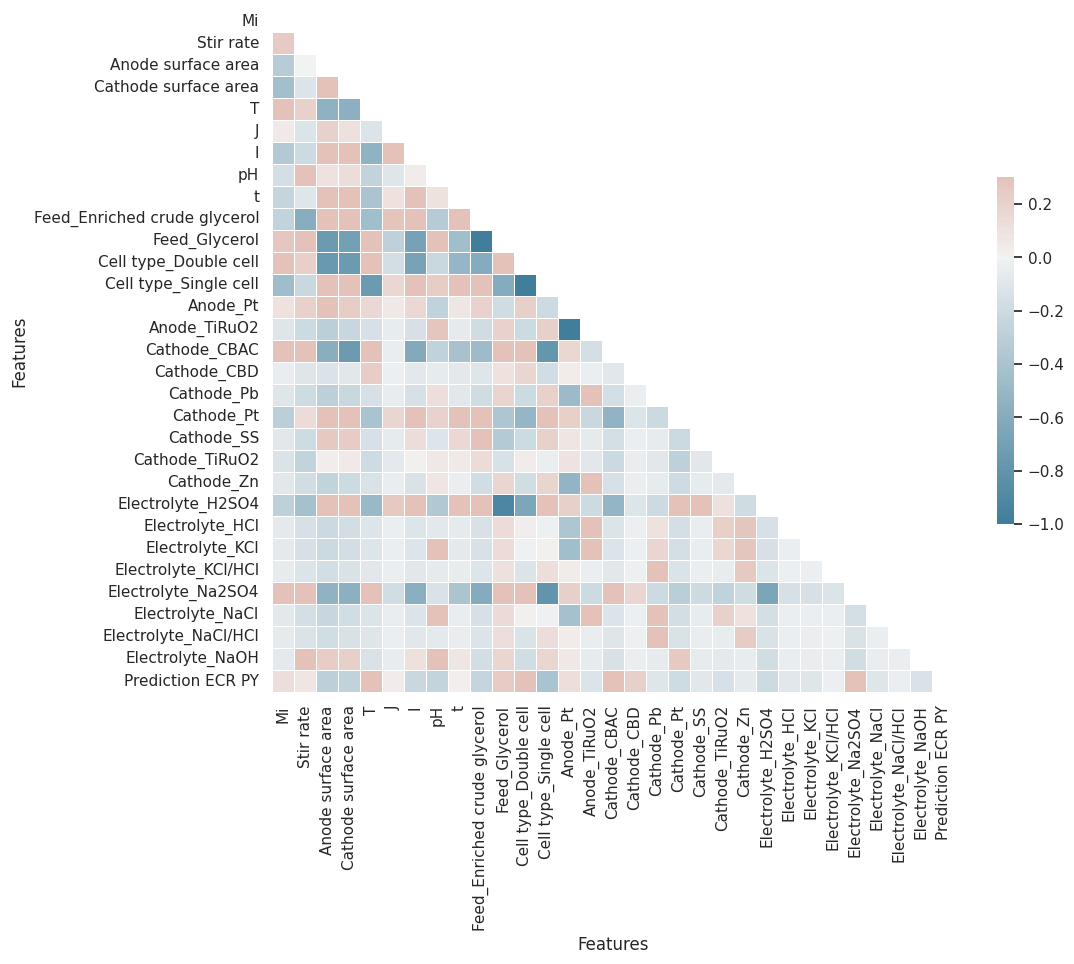

In [4]:
# Create a DataFrame from the predicted labels and the features
d = pd.DataFrame(imp_train_X, columns=[Xi_list])
d['Prediction ECR PY'] = train_predictions

# Compute the correlation matrix
corr_matrix = d.corr()

# Plot the diagonal correlation matrix
sns.set(style="white")

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Set up the matplotlib figure
f = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_matrix, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

# Set x-axis label
plt.xlabel("Features")

# Set y-axis label
plt.ylabel("Features")

PermutationExplainer explainer: 135it [02:57,  1.32s/it]


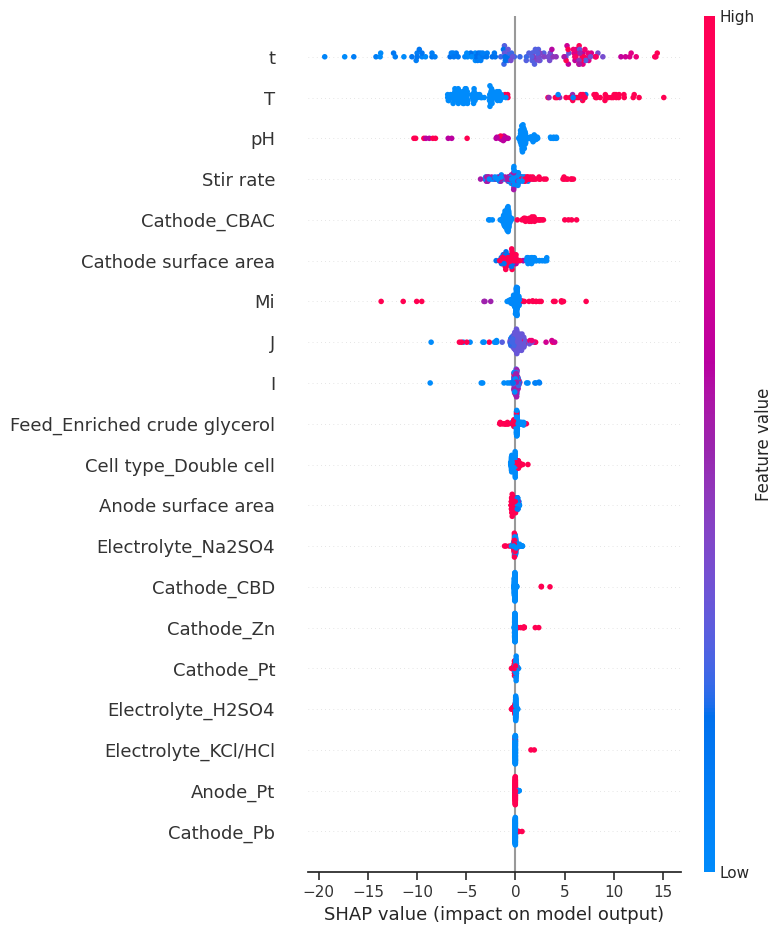

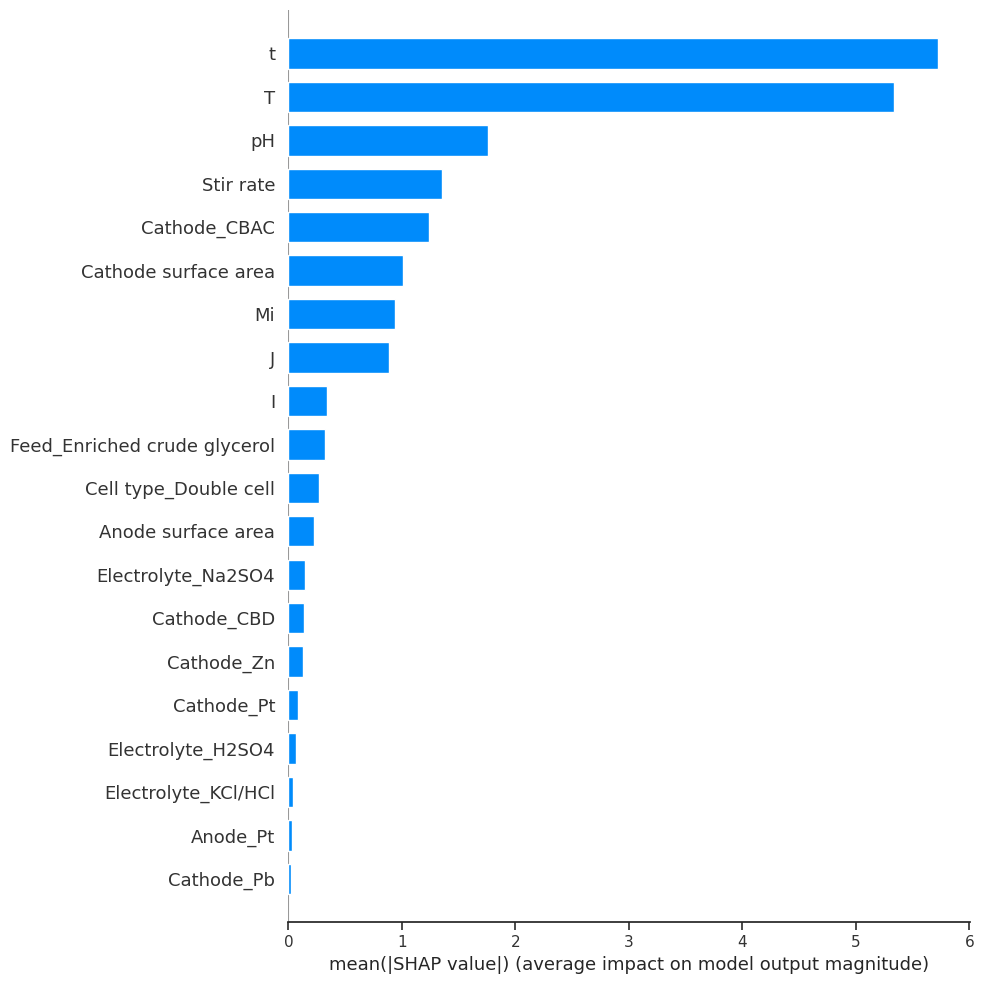

In [5]:
feature_names = Xi_list

explainer = shap.Explainer(model.predict, imp_test_X)
shap_values = explainer(imp_test_X)
shap.summary_plot(shap_values, feature_names=feature_names)

#bar plot
shap.summary_plot(shap_values, feature_names=feature_names, plot_type="bar", plot_size=(10, 10), show=False)


In [ ]:
#Permutation importance for post-trained with sklearn library
from sklearn.inspection import permutation_importance

# Calculate permutation importance
perm_importance = permutation_importance(model, imp_train_X, train_y, n_repeats=30, random_state=42)

# Get the feature importances
feature_importance = perm_importance.importances_mean

# Get the indices of the features ranked by importance
feature_indices = np.argsort(feature_importance)[::-1]

# Print feature importances
for i in feature_indices:
    print(f"Feature {i}: {Xi_list[i]} - Permutation Importance: {feature_importance[i]}")

Feature 4: T - Permutation Importance: 2.108377382717647
Feature 8: t - Permutation Importance: 1.3867557692275412
Feature 1: Stir rate - Permutation Importance: 0.34372290260400984
Feature 7: pH - Permutation Importance: 0.27644368038488004
Feature 3: Cathode surface area - Permutation Importance: 0.2719748034350263
Feature 5: J - Permutation Importance: 0.16804047750140497
Feature 0: Mi - Permutation Importance: 0.13469977528456284
Feature 15: Cathode_CBAC - Permutation Importance: 0.11531147441649131
Feature 6: I - Permutation Importance: 0.029084761359713593
Feature 16: Cathode_CBD - Permutation Importance: 0.025214430288322764
Feature 9: Feed_Enriched crude glycerol - Permutation Importance: 0.02072452354755954
Feature 11: Cell type_Double cell - Permutation Importance: 0.011065106659665125
Feature 2: Anode surface area - Permutation Importance: 0.006139382034722485
Feature 26: Electrolyte_Na2SO4 - Permutation Importance: 0.003876200792836071
Feature 21: Cathode_Zn - Permutation I